https://storage.googleapis.com/deepmind-data/assets/papers/DeepMindNature14236Paper.pdf

http://www.nervanasys.com/demystifying-deep-reinforcement-learning/

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import random
import tensorflow as tf
from itertools import count
from collections import deque
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt
import time as timelib
from scipy import signal
from IPython import display
import os

In [3]:
startPath = os.getcwd()

In [39]:
# Learning parameters
minibatch_size = 32 # As suggested in DeepMind Nature paper
discount_rate = 0.99
episode_max = 5000
tepisode_max = 20
random_action_probability= 0.9 # initial value of e in e-greedy exploration - 0.9
exploration_period=100000
target_reset = 10000 # Deepmind used 10000
max_experience = 1000000
controlbatch = 4
learnrate = 0.0025 # Deepmind used 0.00025
randomTC = 10000 #1000000 for nice and slow
gradientmomentum = 0.95

randommax = 20/controlbatch # multiplied by controlbatch
emin = 0.01

In [5]:
# Plot parameters
plot_every = 5

In [6]:
# Model parameters
L1 = 1.0
L2 = 1.0
M1 = 1.0
M2 = 1.0
model_K = 1.0
model_C = 1.0
model_f = 0.2
model_Dem = 3.0
G = 9.81

In [38]:
# Simulation parameters
dt = 0.01

In [ ]:
ops.reset_default_graph()
session = tf.InteractiveSession()

In [ ]:
# TensorFlow configuration
optimizer = tf.train.RMSPropOptimizer(learning_rate=learnrate, decay=gradientmomentum)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate=learnrate)

We instead use an architecture in which there is a separate output unit for each possible action, and only the state representation is an input to the neural network. The outputs correspond to the predicted Q-values of the individual actions for the input state. The main advantage of this type of architecture is the ability to compute Q-values for all possible actions in a given state with only a single forward pass through the network.

In [8]:
# Network
observation_ind = 3
observation_size = observation_ind*controlbatch
output_size = 21
hidden1_size = 100
hidden2_size = 100
observation = tf.placeholder(tf.float32, (None, observation_size), name="observation")
next_observation = tf.placeholder(tf.float32, (None, observation_size), name="next_observation")

with tf.name_scope("Live") as scope:
    
    Layer1 = tf.Variable(tf.random_normal([observation_size, hidden1_size], stddev=1.0),name="Layer1")
    Layer2 = tf.Variable(tf.random_normal([hidden1_size, hidden2_size], stddev=1.0),name="Layer2")
    Layer3 = tf.Variable(tf.random_normal([hidden2_size, output_size], stddev=1.0),name="Layer3")

    y1 = tf.nn.relu(tf.matmul(observation, Layer1))
    y2 = tf.nn.relu(tf.matmul(y1, Layer2))
    action_scores = tf.matmul(y2, Layer3)
    
    predicted_actions = tf.argmax(action_scores, dimension=1, name="predicted_actions")

with tf.name_scope("Frozen") as scope:
    
    TLayer1 = tf.Variable(Layer1.initialized_value(),name="TLayer1")
    TLayer2 = tf.Variable(Layer2.initialized_value(),name="TLayer2")
    TLayer3 = tf.Variable(Layer3.initialized_value(),name="TLayer3")

    Ty1 = tf.nn.relu(tf.matmul(next_observation, TLayer1))
    Ty2 = tf.nn.relu(tf.matmul(Ty1, TLayer2))
    Taction_scores = tf.matmul(Ty2, TLayer3)

    Tpredicted_actions = tf.argmax(Taction_scores, dimension=1, name="predicted_actions")

In [9]:
# Control parameters
Cmax = 10
C = np.linspace(-Cmax,Cmax,output_size)

In [10]:
# Training:  Placeholders
action_mask = tf.placeholder(tf.float32, (None, output_size), name="action_mask")
rewards = tf.placeholder(tf.float32, (minibatch_size,), name="rewards")
next_observation_mask = tf.placeholder(tf.float32, (None,), name="next_observation_mask")

In [11]:
# Training: Current
masked_action_scores = tf.reduce_sum(action_scores * action_mask, reduction_indices=[1,])

In [12]:
# Training: Future
next_action_scores = tf.to_float(tf.stop_gradient(Taction_scores)) # Break tensor chain
target_values = tf.reduce_max(next_action_scores, reduction_indices=[1,]) # Maximum predicted future reward
future_rewards = rewards + discount_rate * target_values

In [13]:
# Training: Optimisation
with tf.name_scope("optimize") as scope:
    temp_diff = tf.clip_by_value((masked_action_scores - future_rewards), -1, 1) # Clipped to -1 and 1
    #temp_diff = (masked_action_scores - future_rewards)
    prediction_error = tf.square(temp_diff)
    
    # Clipped gradient optimization function
    gradients = optimizer.compute_gradients(prediction_error)
    for i, (grad, var) in enumerate(gradients):
        if grad is not None:
            gradients[i] = (tf.clip_by_norm(grad, 5), var)
    
    train_op = optimizer.apply_gradients(gradients)
    
    # Simple Optimization function:
    #train_op = optimizer.minimize(prediction_error)
    
    #mpe_summary = tf.scalar_summary("mean prediction error", temp_diff)

In [14]:
# Initialisation
session.run(tf.initialize_all_variables())

In [15]:
# Writer
merged = tf.merge_all_summaries()
writer = tf.train.SummaryWriter("Users/davidbrowne/tensorflowlogs/", session.graph_def)

Following previous approaches to playing Atari 2600 games, we also use a simple frame-skipping technique. More precisely, the agent sees and selects actions on every kth frame instead of every frame, and its last action is repeated on skipped frames.

In [16]:
time_ox = 0
experience = deque()
time = 0
episodes = 0

In practice, the behaviour distribution is often selected by an e-greedy policy that follows the greedy policy with probability 1 - e and selects a random action with probability e.

KeyboardInterrupt: 

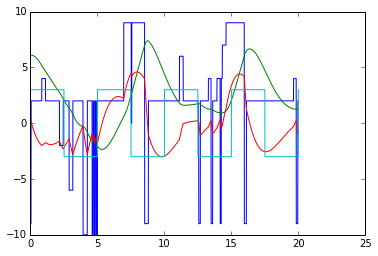

In [37]:
# More initialisation
control = 0
state = np.array([model_Dem, 0.0, model_Dem])
last_observation = np.zeros(controlbatch*observation_ind)
rstate = 0
experiencelog = deque()
new_observation = state
new_observationC = np.array([])
new_action = np.floor(output_size/2)+1
tv = []
controls = []
error = 0
cheat = time_ox
randomflag = 0
randomcount = 0

fig, axes = plt.subplots()

for time_oxx in count():
    time_ox = time_oxx + 1 + cheat
    
    if (time_ox % target_reset)==0:
        #TLayer1 = tf.identity(Layer1)
        #TLayer2 = tf.identity(Layer2)
        #TLayer3 = tf.identity(Layer3) # NB: Change this for 2 hidden layers
        
        # 'Deep' copy
        TLayer1 = tf.Variable(Layer1.initialized_value())
        TLayer2 = tf.Variable(Layer2.initialized_value())
        TLayer3 = tf.Variable(Layer3.initialized_value())       
        session.run(tf.initialize_variables([TLayer1, TLayer2, TLayer3]))
        
    time = time + dt
    tv.append(time)
    
    # Saving previous step
    last_action = new_action
    
    ## ----------------------------------------------------------------
    ## INTERCHANGABLE MODEL
    ## ----------------------------------------------------------------
    # Model & Simulation
    dydx = np.zeros_like(state)
    dydx[0] = state[1]
    dydx[1] = (-model_K*state[0] - model_C*state[1] + control) /M1
    dydx[2] = 0
    target = model_Dem * signal.square(2 * np.pi * model_f * time)
    
    state = state + dydx * dt
    state[2] = target
    
    # Collecting reward
    preverror = error
    error = (abs(state[0]-target))
    
    reward = -error +  np.sign(error-preverror)
    
    ## ----------------------------------------------------------------
    
    # Collecting together data for an observation
    new_observation = state
    
    experiencelog.append((last_observation, last_action, reward, new_observation, target))
    controls.append(control)
    
    # e-greedy control
    n = time_ox
    if n <= exploration_period:
        exploration_p =  random_action_probability
    else:
        #exploration_p =  1 - (n * (1 - random_action_probability)) / (exploration_period)
        exploration_p = np.max([random_action_probability-np.float((n-exploration_period))/100000, emin])
    
    if randomcount > randommax:
        randomflag = 0
        randomcount = 0
        
    if (time_ox % (controlbatch))!=0:
        new_observationC = np.append(new_observationC,new_observation)
    else:
        new_observationC = np.append(new_observationC,new_observation)
        if randomflag == 0:
            if (random.random() < exploration_p) | (time_ox<exploration_period):
                new_action = random.randint(0, output_size - 1)
                randomcount = 0
                randomflag = 1
            else:
                new_actions = session.run( # Selecting control value
                    predicted_actions,
                    {observation: [new_observationC]}
                 )
                new_action = new_actions[0]
        else:
            randomcount += 1
        
        
        # Making a zero output correspond to the most zero action
        mapped_action = (new_action + output_size/2) % output_size
        control = C[mapped_action]
        
        
        # Collecting experience
        experience.append((last_observation, last_action, reward, new_observationC)) # Switched to last action for a logical set of data
        
        last_observation = new_observationC # Reset last observation now that it has been added to experience
        new_observationC = np.array([])
            
        if len(experience) > max_experience:
            experience.popleft()

        # Training
        if len(experience) > minibatch_size:
            samples = random.sample(range(len(experience)), minibatch_size)
            samples = [experience[i] for i in samples]

            Xobservation = np.empty((len(samples), observation_size))
            Xnewobservation = np.empty((len(samples), observation_size))
            Xaction_mask = np.zeros((len(samples), output_size))
            Xrewards = np.zeros((len(samples),))

            for i, (x_observation, x_action, x_reward, x_newobservation) in enumerate(samples):
                Xobservation[i] = x_observation
                Xaction_mask[i][x_action] = 1
                Xrewards[i] = x_reward
                Xnewobservation[i] = x_newobservation
            
            cost, _, = session.run([
                    action_scores,
                    train_op,
                ], { 
                    observation: Xobservation,
                    next_observation: Xnewobservation,
                    action_mask: Xaction_mask,
                    rewards: Xrewards,
                })        

            # Add to tensorboard
            #writer.add_summary(summary, time_oxx)
    
            # Hunting down NaNs
            temp = Layer3.eval()

            if np.isnan(temp).any():
                print np.isnan(Xobservation)
                print np.isnan(Xnewobservation)
                print np.isnan(Xaction_mask)
                print np.isnan(Xrewards)
                break
        
    
    # End of optimization
    if episodes == episode_max:
        break

    if time > tepisode_max:
        
        # Plotting every X episodes
        
        states = [row[3] for row in experiencelog]
        tgt = [row[4] for row in experiencelog]
        x = [row[0] for row in states]
        v = [row[1] for row in states]
        rewardsTotal = sum([row[2] for row in experiencelog])
        
        if (episodes % plot_every) == 0:
            print rewardsTotal, exploration_p, np.mean(x)
            plt.cla()
            axes.plot(tv,controls)
            axes.plot(tv, x)
            axes.plot(tv, v)
            axes.plot(tv,tgt)
            display.display(plt.gcf())
            display.clear_output(wait=True)
            timelib.sleep(1.0)
            
        # Resetting for next episode
        #state = np.array([model_Dem, 0.0, model_Dem])
        #new_action = np.floor(output_size/2)+1
        #new_observation = state
        controls = []
        time = 0
        tv = []
        episodes = episodes + 1
        experiencelog = deque()

In [35]:
saver = tf.train.Saver()
save_path = os.path.join(startPath,'Models','SquareWaveDemandSpringMassDamper.ckpt')
saver.save(session, save_path)
print("Model saved in file: %s" % save_path)

Model saved in file: /Users/davidbrowne/TensorFlowReinforcementLearning/Models/SquareWaveDemandSpringMassDamper.ckpt


In [36]:
temp = session.run([action_scores], { 
                    observation: Xobservation,
                })

print temp

Layer2.eval()

[array([[ -3.53714447e+02,  -8.03266357e+02,   1.22294487e+02,
          5.91135071e+02,  -5.59202271e+02,  -3.20922913e+02,
         -5.25566177e+01,  -3.80097351e+02,   9.40915771e+02,
         -1.96805954e+01,  -2.25999451e+02,   2.56781860e+02,
         -1.28241081e+01,   3.29797211e+02,   5.92354919e+02,
          1.32190186e+02,   4.45812378e+02,  -6.07940369e+02,
         -1.82958237e+02,  -1.04578467e+03,   2.68716164e+01],
       [ -1.82031342e+02,  -5.65749451e+02,   6.38910446e+01,
          6.14388428e+02,  -3.21628967e+02,  -2.84060287e+01,
         -6.41349106e+01,   9.10333710e+01,   4.85505280e+02,
          1.23032295e+02,  -2.97098751e+01,   1.07542496e+01,
          7.06711655e+01,   1.81987015e+02,   5.09477600e+02,
          6.75641098e+01,   5.70253601e+01,  -1.25011345e+02,
         -3.49960709e+01,  -4.97288177e+02,   1.81653442e+02],
       [ -8.64797134e+01,  -1.77154343e+02,  -5.22908508e+02,
         -1.95718033e+02,  -1.51876202e+01,   1.68906570e+02,
     

array([[ 2.06471729,  1.04396737,  1.47876537, ...,  1.42134762,
         0.32312414,  0.80996466],
       [ 2.20371079, -0.57335418,  1.64383781, ..., -1.88604999,
         0.37968019, -1.14255643],
       [-0.98379105, -2.89269328, -0.4072929 , ..., -0.87091047,
         0.32295251, -0.31334525],
       ..., 
       [ 0.80531102,  1.13045406, -0.2016366 , ...,  1.3619957 ,
         2.82647896,  1.61315632],
       [ 0.11871616,  0.06555939, -1.02874529, ...,  1.04716396,
         0.26738289, -0.24079752],
       [-1.34279239,  1.36712372, -0.90701181, ...,  1.98195708,
        -0.39374581, -0.15122138]], dtype=float32)

In [34]:
episodes

1054